In [6]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm

使用 03-15 年的mask后的数据来进行后续的泰勒图的相关性计算

In [7]:
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/ordata"
file_in = "sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
ds_obs = xr.open_dataset(path_in + "/" + file_in)

model_set = {} # 存放不同模式结果

path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res"
file_in = "mask_mean_vr_03-15.nc"
model_set["vr"] = xr.open_dataset(path_in + "/" + file_in)

path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res"
file_in = "mask_mean_rcm_03-15.nc"
model_set["rcm"] = xr.open_dataset(path_in + "/" + file_in)


进行时间平均，绘制空间上的taylor图

In [8]:
months = ["4","5","6","7","8"]
model_types = ["vr", "rcm"]

model_stats = {} # 存放 VR RCM 的位置

for model_type in model_types:
    month_stats = {} # 存放逐月的统计量
    # add every month
    for month_ind in months:
        # count month mean
        months_obs_mean = ds_obs["tm"].loc[ds_obs.time.dt.month==int(month_ind)].mean(dim=["time"])
        months_vr_mean = model_set[model_type]["t2m"].loc[model_set[model_type].Time.dt.month==int(month_ind)].mean(dim=["Time"]) - 273.15
        # ND to 1D
        temp_obs = months_obs_mean.values.ravel()
        temp_vr = months_vr_mean.values.ravel()
        # remove NaN
        temp_obs = temp_obs[~np.isnan(temp_obs)]
        temp_vr = temp_vr[~np.isnan(temp_vr)]
        # count taylor stats
        # pred1 , refer
        # month_stats[month_ind] = sm.taylor_statistics(np.array(months_mod_mean).ravel(),np.array(months_obs_mean).ravel())
        # add
        month_stats[month_ind] = sm.target_statistics(temp_vr, temp_obs)
    # add all year
    # count year(4-8 months) mean
    months_obs_mean = ds_obs["tm"].mean(dim=["time"]) 
    months_vr_mean = model_set[model_type]["t2m"].mean(dim=["Time"]) - 273.15
    # ND to 1D
    temp_obs = months_obs_mean.values.ravel()
    temp_vr = months_vr_mean.values.ravel()
    # remove NaN
    temp_obs = temp_obs[~np.isnan(temp_obs)]
    temp_vr = temp_vr[~np.isnan(temp_vr)]
    # add
    month_stats['all'] = sm.target_statistics(temp_vr, temp_obs)
    # add module set
    model_stats[model_type] = month_stats


In [9]:
model_stats['vr']['4']

{'bias': -1.3816150479602838,
 'crmsd': 2.9168049599766093,
 'rmsd': 3.2274776819873003,
 'type': 'unnormalized'}

进行标准化等数据预处理

In [10]:
# year_select = ["2004","2005","2006","2007","2008"]
months = ["4","5","6","7","8","all"]
model_types = ["vr", "rcm"]
model_plot = {} # 存放不同模式的taylor plot的结果

# 将泰勒图诸要素整理到 model_plot 中，并接着绘图
for model_type in model_types:

    bias  = []
    crmsd = []
    rmsd = []
    # sdev_obs = []
    # append obs
    #----- normilized -----
    # sdev.append(model_stats[model_type][month_ind]['sdev'][0]/model_stats[model_type][month_ind]['sdev'][0])
    # crmsd.append(model_stats[model_type][month_ind]['crmsd'][0]/model_stats[model_type][month_ind]['sdev'][0])
    # ccoef.append(model_stats[model_type][month_ind]['ccoef'][0])

    for month_ind in months:

        # statistics can be normalized
        # obs sdev=1 crmsd=0 ccoef=1
        # append 4-8 months
        #----- normilized -----
        # sdev.append(model_stats[model_type][month_ind]['sdev'][1]/model_stats[model_type][month_ind]['sdev'][0])
        # crmsd.append(model_stats[model_type][month_ind]['crmsd'][1]/model_stats[model_type][month_ind]['sdev'][0])
        # ccoef.append(model_stats[model_type][month_ind]['ccoef'][1])

        # add into plot pandas
        bias.append(model_stats[model_type][month_ind]['bias'])
        crmsd.append(model_stats[model_type][month_ind]['crmsd'])
        rmsd.append(model_stats[model_type][month_ind]['rmsd'])

    # append all round year
    bias  = np.array(bias)
    crmsd = np.array(crmsd)
    rmsd = np.array(rmsd)

    # add to model plot
    model_plot[model_type] = {"bias":bias, "crmsd":crmsd, "rmsd":rmsd}

泰勒图绘制<br>
拆分为两部分，RCM和VR，使用overlay来绘制

In [11]:
# 对于RMSD的理解。
# RMSD既刻画了变率，又刻画了平均值，这张图的半径是总体的RMSD，x轴是 unbias RMSD
model_plot['vr']['bias'][0]**2 + model_plot['vr']['crmsd'][0]**2 - model_plot['vr']['rmsd'][0]**2

-8.724316717945158e-07

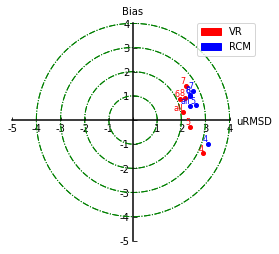

In [21]:
# label = ["Apr","May","Jun","Jul","Aug","ALL"]
label = ["4","5","6","7","8","all"]
circles  = np.arange(0,5,1)

sm.target_diagram(model_plot['vr']['bias'],model_plot['vr']['crmsd'],model_plot['vr']['rmsd'], \
markerLabel = label, markerLabelColor = 'r', \
                    markerColor = 'r', \
                    # markerLegend = 'on', \
                    circles = circles , \
                    markerSize = 8, \
                    ticks = np.arange(-5,5,1), \
                    axismax = 5, \
                      circleLineSpec = '-.g', circleLineWidth = 1.)

sm.target_diagram(model_plot['rcm']['bias'],model_plot['rcm']['crmsd'],model_plot['rcm']['rmsd'], \
markerLabel = label, markerLabelColor = 'b', \
                    markerColor = 'b', \
                        # markerLegend = 'on', \
                        overlay = 'on', \
                            circles = circles , \
                            markerSize = 8, \
                            axismax = 5, \
                                ticks = np.arange(-5,5,1), \
                      circleLineSpec = '-.g', circleLineWidth = 1.)



# plt.title("title")

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='VR')
blue_patch = mpatches.Patch(color='blue', label='RCM')
plt.legend(handles=[red_patch, blue_patch], loc=[0.85,0.85])


pic_output_path = "./output_pic/"
plt.savefig(pic_output_path + "target_normalized_2003-2015_space",dpi=300,facecolor='white')